In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 학습 모델 저장을 위한 라이브러리
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# ===== 파일 경로 =====
past_file   = "../../data/투수_데이터_최종.csv"      # 과거 FA 데이터
future_file = "../../data/2026_FA예정_투수.csv"     # 2026 예정자 데이터

In [3]:
# ===== 기본 설정 =====
features_num = ["종합 WAR","ERA","이닝수","탈삼진","FIP","투구수","피장타율","사사구"]
cat_cols     = ["투","세부 포지션"]
target_col   = "AAV"
name_col     = "선수명"

In [4]:
# -------------------------
# 1) 데이터 로드
# -------------------------
df_past = pd.read_csv(past_file)
df_future = pd.read_csv(future_file)

In [5]:
# -------------------------
# 2) '투' 컬럼 정규화
# -------------------------
for df in [df_past, df_future]:
    df["투"] = df["투"].astype(str)
    df.loc[df["투"].str.contains("우", na=False), "투"] = "우투"
    df.loc[df["투"].str.contains("좌", na=False), "투"] = "좌투"

In [6]:
df_past[target_col] = df_past["FA 계약 총액"] / df_past["FA 계약 연수"].replace(0, np.nan)

In [7]:
mode_cols = cat_cols
df_past_mode = df_past.groupby(name_col)[mode_cols].agg(lambda x: x.mode()[0]).reset_index()
df_future_mode = df_future.groupby(name_col)[mode_cols].agg(lambda x: x.mode()[0]).reset_index()

df_past_mean = df_past.groupby(name_col, as_index=False).mean(numeric_only=True)
df_future_mean = df_future.groupby(name_col, as_index=False).mean(numeric_only=True)

df_past = pd.merge(df_past_mode, df_past_mean, on=name_col)
df_future = pd.merge(df_future_mode, df_future_mean, on=name_col)

In [8]:
# 3. future 기준으로 원핫인코딩
future_ohe = pd.get_dummies(df_future.drop(columns=[target_col], errors="ignore"), 
                             columns=cat_cols)
past_ohe   = pd.get_dummies(df_past.drop(columns=[target_col], errors="ignore"), 
                             columns=cat_cols)
# AAV 다시 붙이기
past_ohe[target_col] = df_past[target_col]

In [9]:
# future_ohe 기준으로 past_ohe 컬럼 맞추기
for col in future_ohe.columns:
    if col not in past_ohe.columns:
        past_ohe[col] = 0

for col in past_ohe.columns:
    if col not in future_ohe.columns:
        future_ohe[col] = 0

# 순서 동일하게 맞추기
past_ohe = past_ohe[sorted(future_ohe.columns)]
future_ohe = future_ohe[sorted(future_ohe.columns)]

In [10]:
print("past shape:", past_ohe.shape)
print("future shape:", future_ohe.shape)

past shape: (79, 53)
future shape: (16, 53)


In [11]:
# 5) 가중치 계산 (상관계수 기반)
# -------------------------
# 원핫인코딩된 투, 세부 포지션 컬럼 추출
onehot_cols = [c for c in future_ohe.columns if c.startswith("투_") or c.startswith("세부 포지션_")]

# 최종 features 구성 (예정 데이터에 존재하는 수치형 피처 + 원핫 컬럼)
features = [f for f in features_num if f in future_ohe.columns] + onehot_cols

corr = past_ohe[features + [target_col]].corr()[target_col].drop(target_col).abs()
weights = corr / corr.sum()

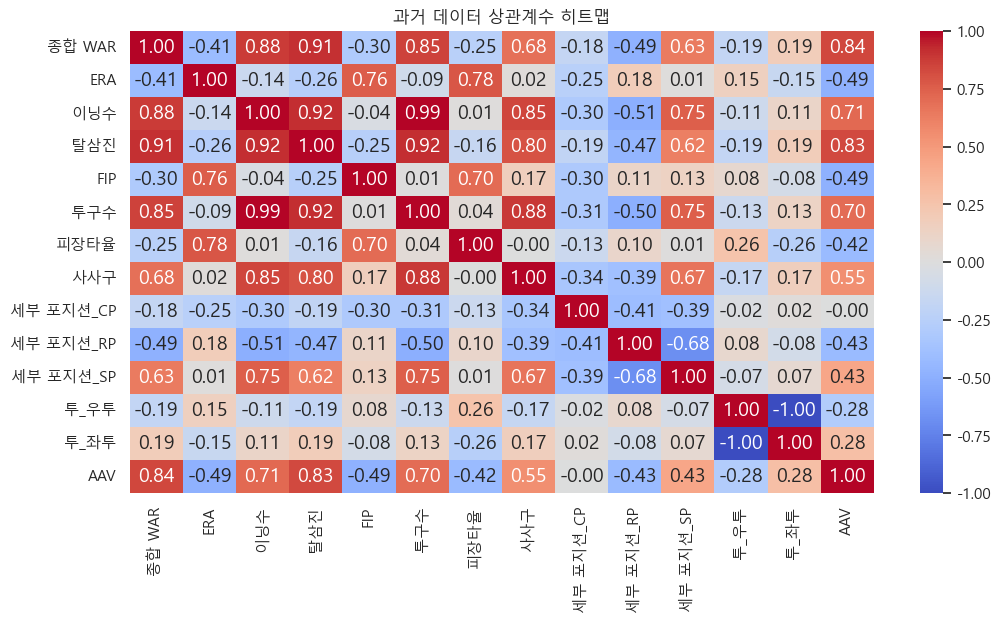

In [20]:
# 상관계수 계산 & 히트맵
# -------------------------
corr_matrix = past_ohe[features + [target_col]].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("과거 데이터 상관계수 히트맵")
plt.show()

In [22]:
# 가중치 표 출력
print("📊 가중치 테이블")
print(weights.sort_values(ascending=False))

📊 가중치 테이블
종합 WAR       0.129523
탈삼진          0.129318
이닝수          0.110499
투구수          0.107806
사사구          0.085247
FIP          0.075660
ERA          0.075212
세부 포지션_SP    0.066556
세부 포지션_RP    0.065843
피장타율         0.065634
투_우투         0.044114
투_좌투         0.044114
세부 포지션_CP    0.000472
Name: AAV, dtype: float64


In [24]:
def get_scores(df):
    X = StandardScaler().fit_transform(df[features])
    return np.dot(X, weights)

In [28]:
# 점수 계산
future_ohe["점수"] = get_scores(future_ohe)

# 선수별 평균 점수 랭킹
ranking = (
    future_ohe.groupby(name_col)["점수"]
    .mean()
    .reset_index()
    .sort_values(by="점수", ascending=False)
    .reset_index(drop=True)
)

ranking["점수"] = ranking["점수"].round(2)

ranking

,선수명,점수
0,양현종,1.60
1,최원준,1.01
2,이영하,0.13
3,김태훈,-0.01
4,서진용,-0.01
5,장필준,-0.01
6,김범수,-0.07
7,김상수,-0.08
8,이승현,-0.10
9,홍건희,-0.12


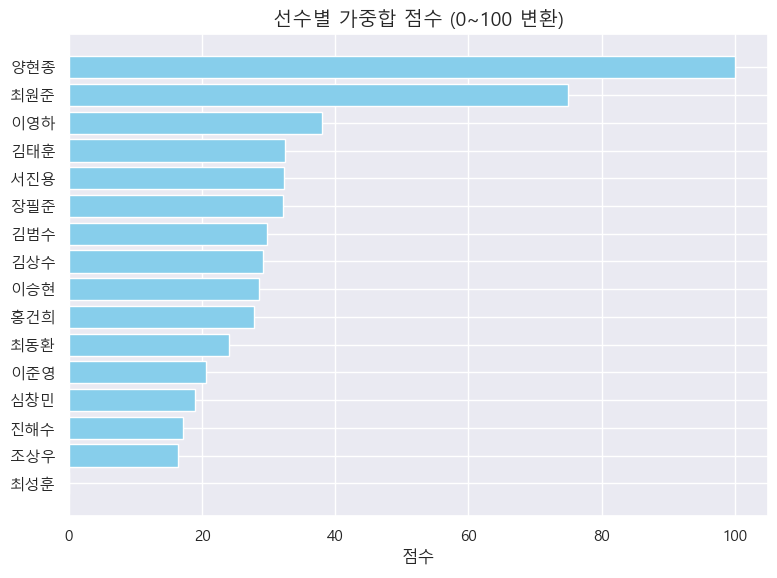

In [34]:
from sklearn.preprocessing import MinMaxScaler

future_ohe["점수"] = get_scores(future_ohe)
scaler = MinMaxScaler(feature_range=(0, 100))
ranking = future_ohe.groupby(name_col)["점수"].mean().reset_index()
ranking["점수"] = scaler.fit_transform(ranking[["점수"]])
ranking = ranking.sort_values(by="점수", ascending=False)

# 그래프
plt.figure(figsize=(8, 6))
plt.barh(ranking[name_col], ranking["점수"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("선수별 가중합 점수 (0~100 변환)", fontsize=14)
plt.xlabel("점수", fontsize=12)
plt.tight_layout()
plt.show()